# Trialling Trading Strategies

In [11]:
# Available imports
import pandas as pd
import numpy as np
import statistics
import math

# Illegal import but only used for graphing
# NOTE: rerunning setup_env.py will install these for you :)
import matplotlib.pyplot as plt
import plotly.graph_objects as go

## Moving Averages

In [12]:
df = pd.read_csv('round-2-island-data-bottle/prices_round_2_day_-1.csv', sep=";")
# print(df)

### Kelp

In [13]:
short_window = 50
long_window = 200

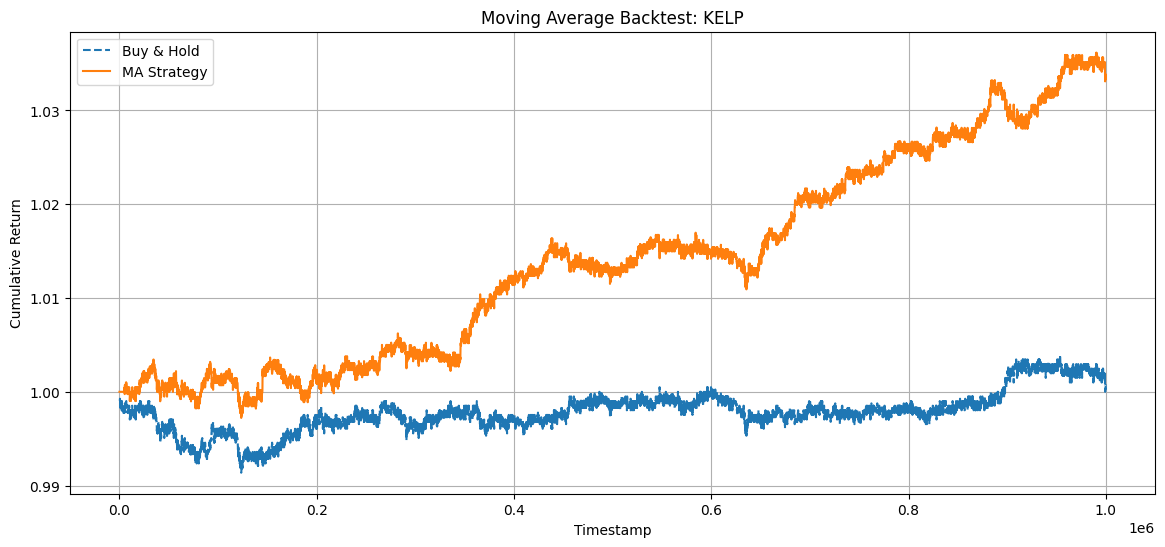

In [14]:
# Filter product
product = "KELP"
kelp_df = df[df['product'] == product].copy()
kelp_df = kelp_df.sort_values(by='timestamp')  # ensure correct time order

kelp_df['SMA_short'] = kelp_df['mid_price'].rolling(window=short_window, min_periods=1).mean()
kelp_df['SMA_long'] = kelp_df['mid_price'].rolling(window=long_window, min_periods=1).mean()

# Generate Signals
kelp_df['Signal'] = 0
kelp_df.loc[kelp_df['SMA_short'] < kelp_df['SMA_long'], 'Signal'] = 1  # long
kelp_df.loc[kelp_df['SMA_short'] > kelp_df['SMA_long'], 'Signal'] = -1 # short

kelp_df['Position'] = kelp_df['Signal'].shift(1)  # avoid lookahead bias

# Calculate Returns
kelp_df['Price_Return'] = kelp_df['mid_price'].pct_change()
kelp_df['Strategy_Return'] = kelp_df['Position'] * kelp_df['Price_Return']
kelp_df['Cumulative_Strategy'] = (1 + kelp_df['Strategy_Return']).cumprod()
kelp_df['Cumulative_Market'] = (1 + kelp_df['Price_Return']).cumprod()

# Plot
plt.figure(figsize=(14,6))
plt.plot(kelp_df['timestamp'], kelp_df['Cumulative_Market'], label='Buy & Hold', linestyle='--')
plt.plot(kelp_df['timestamp'], kelp_df['Cumulative_Strategy'], label='MA Strategy')
plt.title(f'Moving Average Backtest: {product}')
plt.xlabel('Timestamp')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


In [15]:
kelp_df['short_ma'] = kelp_df['mid_price'].rolling(window=short_window).mean()
kelp_df['long_ma'] = kelp_df['mid_price'].rolling(window=long_window).mean()

# Define Buy and Sell signals
kelp_df['buy_signal'] = np.where(kelp_df['short_ma'] < kelp_df['long_ma'], 1, 0)
kelp_df['sell_signal'] = np.where(kelp_df['short_ma'] > kelp_df['long_ma'], 1, 0)

# Create the plotly figure
fig = go.Figure()

# Add the KELP Price line
fig.add_trace(go.Scatter(x=kelp_df['timestamp'], y=kelp_df['mid_price'], mode='lines', name='KELP Price', line=dict(color='blue')))

# Add short-term moving average
fig.add_trace(go.Scatter(x=kelp_df['timestamp'], y=kelp_df['short_ma'], mode='lines', name='Short-term MA (5)', line=dict(color='green')))

# Add long-term moving average
fig.add_trace(go.Scatter(x=kelp_df['timestamp'], y=kelp_df['long_ma'], mode='lines', name='Long-term MA (20)', line=dict(color='red')))

# Add buy signals (green dots)
fig.add_trace(go.Scatter(x=kelp_df['timestamp'][kelp_df['buy_signal'] == 1], 
                         y=kelp_df['mid_price'][kelp_df['buy_signal'] == 1], 
                         mode='markers', 
                         name='Buy Signal', 
                         marker=dict(color='green', size=8)))

# Add sell signals (red dots)
fig.add_trace(go.Scatter(x=kelp_df['timestamp'][kelp_df['sell_signal'] == 1], 
                         y=kelp_df['mid_price'][kelp_df['sell_signal'] == 1], 
                         mode='markers', 
                         name='Sell Signal', 
                         marker=dict(color='red', size=8)))

# Update layout for better appearance
fig.update_layout(title='KELP Price with Moving Averages and Buy/Sell Signals',
                  xaxis_title='Timestamp',
                  yaxis_title='Price',
                  template='plotly_dark',  # Optional: for dark background
                  hovermode='x unified')  # Show all info on hover

# Show the interactive plot
fig.show()